<a href="https://colab.research.google.com/github/arturoliduena/cifar10-image-recognition/blob/main/versions/cnn_cifar10_tf2_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import random
import os
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import pandas as pd

Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [2]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Montamos modelo**

In [3]:
initializer = ks.initializers.he_normal()
input_tensor = ks.Input(shape=(32, 32, 3))
resized_images = ks.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)


In [4]:
vgg = vgg16.VGG16(include_top=False, weights="imagenet",input_shape=(224, 224,3),input_tensor=resized_images)

58900480/58889256 [==============================] - 2s 0us/step


In [5]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

In [6]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [7]:
vgg_model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

In [8]:
print(vgg_model.trainable)   

True


In [9]:
pd.set_option('max_colwidth', None) 
layers= [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type','Name', 'Trainable?'])

,Layer type,Name,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7fc201958b50>,input_1,True
1,<keras.layers.core.lambda_layer.Lambda object at 0x7fc201973150>,lambda,True
2,<keras.layers.convolutional.Conv2D object at 0x7fc2849ed550>,block1_conv1,True
3,<keras.layers.convolutional.Conv2D object at 0x7fc201921ad0>,block1_conv2,True
4,<keras.layers.pooling.MaxPooling2D object at 0x7fc201085850>,block1_pool,True
5,<keras.layers.convolutional.Conv2D object at 0x7fc1f0398250>,block2_conv1,True
6,<keras.layers.convolutional.Conv2D object at 0x7fc204eb8b50>,block2_conv2,True
7,<keras.layers.pooling.MaxPooling2D object at 0x7fc1f03a1a50>,block2_pool,True
8,<keras.layers.convolutional.Conv2D object at 0x7fc1f039d690>,block3_conv1,True
9,<keras.layers.convolutional.Conv2D object at 0x7fc1f03967d0>,block3_conv2,True


In [10]:
flag_trainable = False

for layer in vgg_model.layers:
  if layer.name == 'block4_conv1':
    flag_trainable = True
  layer.trainable = flag_trainable

In [11]:
layers= [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type','Name', 'Trainable?'])

,Layer type,Name,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7fc201958b50>,input_1,False
1,<keras.layers.core.lambda_layer.Lambda object at 0x7fc201973150>,lambda,False
2,<keras.layers.convolutional.Conv2D object at 0x7fc2849ed550>,block1_conv1,False
3,<keras.layers.convolutional.Conv2D object at 0x7fc201921ad0>,block1_conv2,False
4,<keras.layers.pooling.MaxPooling2D object at 0x7fc201085850>,block1_pool,False
5,<keras.layers.convolutional.Conv2D object at 0x7fc1f0398250>,block2_conv1,False
6,<keras.layers.convolutional.Conv2D object at 0x7fc204eb8b50>,block2_conv2,False
7,<keras.layers.pooling.MaxPooling2D object at 0x7fc1f03a1a50>,block2_pool,False
8,<keras.layers.convolutional.Conv2D object at 0x7fc1f039d690>,block3_conv1,False
9,<keras.layers.convolutional.Conv2D object at 0x7fc1f03967d0>,block3_conv2,False


In [12]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

170508288/170498071 [==============================] - 11s 0us/step


In [13]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [14]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train_scaled = y_train[:-10000]

In [15]:
x_val = x_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [16]:
#Validación
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train_scaled.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


## 2. Arquitectura de red del modelo + capa VGG - Proyecto 9




In [17]:
output_from_vgg16 = 25088

In [18]:
model_with_vgg = ks.Sequential()


model_with_vgg.add(vgg_model)

model_with_vgg.add(ks.layers.Dense(512, activation='relu',input_shape=(output_from_vgg16, )))
model_with_vgg.add(ks.layers.Dropout(0.3))
model_with_vgg.add(ks.layers.Dense(512, activation='relu'))
model_with_vgg.add(ks.layers.Dropout(0.3))
model_with_vgg.add(ks.layers.Dense(10, activation='softmax'))

model_with_vgg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 25088)             14714688  
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 27,828,042
Trainable params: 26,092,554
No

In [19]:
from tensorflow.keras.optimizers import Adam

In [20]:
new_adam = Adam(learning_rate=2e-5)

In [21]:
model_with_vgg.compile(loss='sparse_categorical_crossentropy', optimizer=new_adam, metrics=['accuracy'])

Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584

## 3. Optimizador, función error


In [23]:
vgg.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 4. Preparamos los datos

Cargamos los datos de CIFAR10 de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:** 
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [24]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0


In [25]:
y_train_label = y_train

y_test
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

Obtenemos un array con todas las labels de CIFAR10

In [26]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


Pintemos una muestra de las imagenes del dataset CIFAR10, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


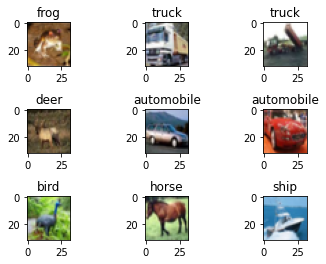

In [27]:
# Pintemos una muestra de las las imagenes del dataset MNIST

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):

    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(cifar10_labels[y_train_label[i,0]])

plt.subplots_adjust(hspace = 1)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [28]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución espera una matriz de 4 campos** (más parecido a "imagenes"), en el caso de MNIST. CIFAR10 ya tiene el shape adecuado, así que no tenemos que hacer nada, pero como siempre decimos: es mejor que comprobeis su tamaño.

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [29]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
Validation: X=(10000, 32, 32, 3), y=(10000, 1)


**Callbacks**

In [30]:
# Callback con EarlyStopping basado en Accuracy
callback_accuracy = EarlyStopping(monitor='val_accuracy', patience=5)

# Callback con EarlyStopping basad0 en Loss
callback_loss = EarlyStopping(monitor='val_loss', patience=5)

**Modelo checkpoint**

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [32]:
callback_earlystopping = EarlyStopping(monitor='val_loss', patience=5)

In [33]:
callback_modelcheckpoint = ModelCheckpoint('/tmp/modelchk', monitor='val_accuracy', 
                                           verbose=1, save_best_only=True, 
                                           save_weights_only=True)

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [34]:
history = model_with_vgg.fit(x=x_train_scaled, y=y_train, batch_size=32,
                             epochs=20, callbacks=[callback_modelcheckpoint, callback_earlystopping], 
                             validation_data=(x_val_scaled, y_val))

Epoch 1/20
1250/1250 [==============================] - ETA: 0s - loss: 0.9989 - accuracy: 0.6521
Epoch 1: val_accuracy improved from -inf to 0.81260, saving model to /tmp/modelchk
1250/1250 [==============================] - 619s 483ms/step - loss: 0.9989 - accuracy: 0.6521 - val_loss: 0.5373 - val_accuracy: 0.8126
Epoch 2/20
1250/1250 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.8257
Epoch 2: val_accuracy improved from 0.81260 to 0.82960, saving model to /tmp/modelchk
1250/1250 [==============================] - 603s 482ms/step - loss: 0.5105 - accuracy: 0.8257 - val_loss: 0.4985 - val_accuracy: 0.8296
Epoch 3/20
1250/1250 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8809
Epoch 3: val_accuracy improved from 0.82960 to 0.87250, saving model to /tmp/modelchk
1250/1250 [==============================] - 603s 482ms/step - loss: 0.3497 - accuracy: 0.8809 - val_loss: 0.3715 - val_accuracy: 0.8725
Epoch 4/20
1250/1250 [==================

## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [35]:
_, acc = model_with_vgg.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 87.880


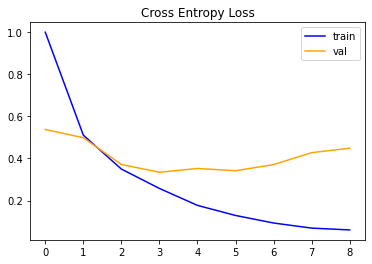

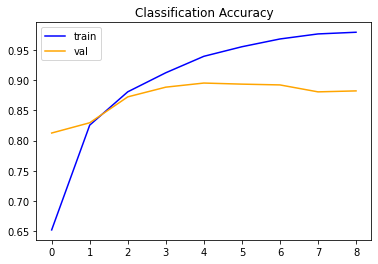

In [36]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.legend()
plt.show()

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [37]:
predictions = model_with_vgg.predict(x_test)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [38]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label[0]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

Dibujamos las primeras imagenes, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo. Aunque primero he impreso las etiquetas para que tengamos una referencia al grafico.

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


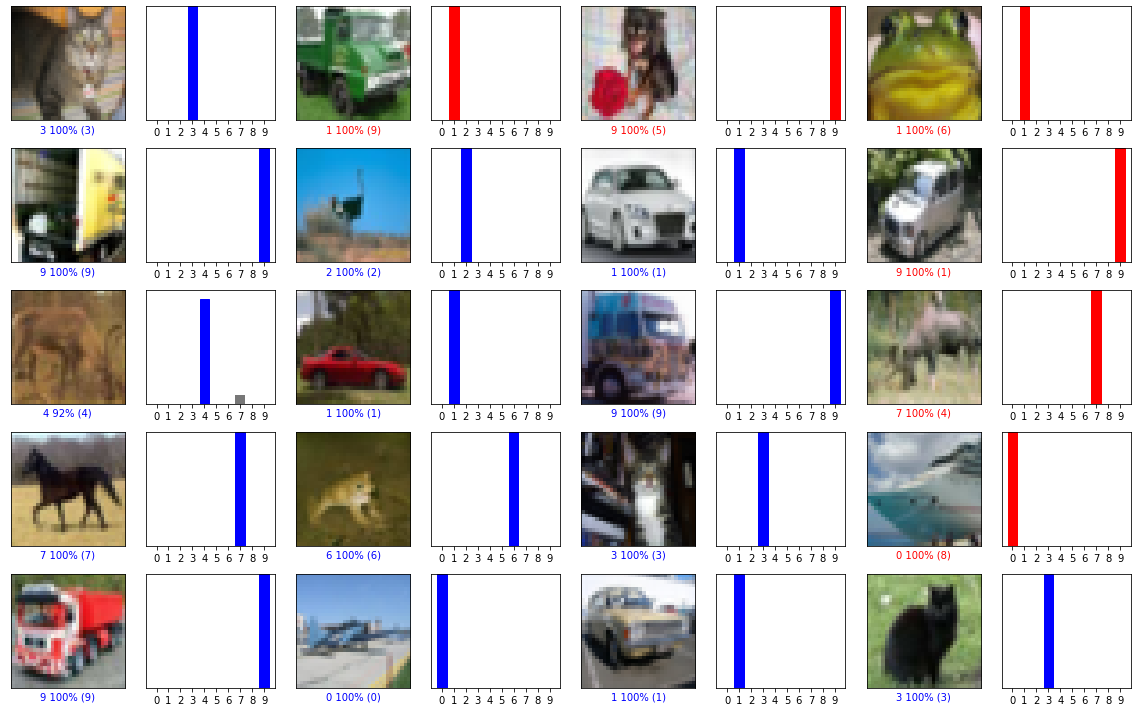

In [39]:
i = 0
for l in cifar10_labels:
    print(i, l)
    i += 1

num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [40]:
ruta_googledrive = "/content/drive/MyDrive/Data Science/Deep Learning/Cifar10" # A revisar en vuestra instancia

vgg.save(ruta_googledrive+'cifar10_base_model.h5')